# Analysis of Beijing housing prices

## Content
*Some of the code was taken from the course cds-106@FHGR*

- Imports
- Defining functions
- Running functions

## Imports

In [175]:
# standard libraries
import os
from datetime import datetime
from PIL import Image
from IPython.display import IFrame
import math

# data handling and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# for Q-Q plots
import scipy.stats as stats

# warnings
import warnings
warnings.filterwarnings("ignore")  # disable warnings in this notebook

## Defining functions

### Dataframe handling

In [66]:
'''
# return encoding of file
def detectEncoding(PATH):
    with open(PATH, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(10000))
    return result
'''

"\n# return encoding of file\ndef detectEncoding(PATH):\n    with open(PATH, 'rb') as rawdata:\n        result = chardet.detect(rawdata.read(10000))\n    return result\n"

In [67]:
# loading the data
def createDataframeFromCSV(PATH, encoding, separator):
    missing_values = ["n/a", "na", "--", ""]  # List of missing value types
    if os.path.exists(PATH) and encoding !="" and separator != "":
        rawData = pd.read_csv(PATH, encoding=encoding, sep=separator, na_values = missing_values)
        return rawData  # return dataframe
    else:
        return "ERROR"  # return error

### Profile report

In [68]:
# create ProfileReport
def createProfileReport(df):
    dt = datetime.now().strftime("%H%M%d%m%Y")  # current dateTime for fileName
    profile = ProfileReport(df, minimal=True)
    fileName = f"DataAnalysis{dt}"
    profile.to_file(output_file=fileName)
    return f"{fileName}.html"

### Data analysis

In [69]:
def getMissingValuesDF(df):
    missingValues = df.isnull().mean().to_dict()
    for column in df.columns:
        if missingValues[column] == 0:
            del missingValues[column]
    missingValues = pd.DataFrame(list(missingValues.items()), columns=['columnName','missingValuePercentage'])
    return missingValues

In [70]:
def getMissingValuesGroupedBy(df, missingValueColumn, groupByColumn):
    df = df.copy()
    df[f'{missingValueColumn}_null'] = np.where(df[missingValueColumn].isnull(),1,0)
    print(f"Percentage of missing values in the {missingValueColumn} variable: {df[f'{missingValueColumn}_null'].mean()}")
    print(f"Percentage of missing values in the {missingValueColumn} variable grouped by: {df.groupby([groupByColumn])[f'{missingValueColumn}_null'].mean()}")

In [71]:
def detectSkewedBoundaries(df, columnName, distance):  # Function to find upper and lower boundaries for skewed distributions
    # Let's calculate the boundaries for skewed distributions
    # The parameter "distance" gives us the option to estimate 1.5 times or 3 times the IQR when defining the boundaries.
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)

    lower_boundary = df[columnName].quantile(0.25) - (IQR * distance)
    upper_boundary = df[columnName].quantile(0.75) + (IQR * distance)

    print("upper boundary:", upper_boundary, "| lower boundary:",  lower_boundary)
    #number and percentage of outliers
    print(f'total number of rows: {len(df)}')
    print(f'Having {columnName} changes: {len(df[df[columnName] > upper_boundary])}')
    print(f'% of having {columnName}: {len(df[df[columnName] > upper_boundary]) / len(df)}')

In [72]:
def detectNormalBoundaries(df, columnName):  # Function to find upper and lower boundaries for normally distributed variables.
    # Calculate the boundaries for a Gaussian distribution
    upper_boundary = df[columnName].mean() + 3 * df[columnName].std()
    lower_boundary = df[columnName].mean() - 3 * df[columnName].std()

    print("upper boundary:", upper_boundary, "| lower boundary:",  lower_boundary)
    # number and percentage of outliers
    print(f'total number of rows: {len(df)}')
    print(f'rows with more than {int(upper_boundary)} (right end outliers): {len(df[df[columnName] > upper_boundary])}')
    print(f'% right end outliers: {len(df[df[columnName] > upper_boundary]) / len(df)}')

In [73]:
# detecting and printing information about rare lables
def detectRareLabels(df, columnName):
    data = df[columnName].value_counts()/len(df[columnName])
    print(f"Number of labels in the {columnName} variable: {df[columnName].nunique()}")
    print(f"List of the labels in the {columnName} variable: {df[columnName].unique()}")
    print(f"Value counts percentage for each label:")
    return data

In [74]:
def getBaseline(df, predictionColumn, testSize=0.2):  # We can use the baseline to test if our machine learning achieves a better result than just predicting the mean for every price
    X = df[list(df.columns)] # Split X and Y and Train and Test Set -> X isn't needed for calculating baseline so we use all columns
    y = df[predictionColumn]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=20)
    print(f"Prediction variable is: {predictionColumn}")
    print("---------------------------------------------------")
    errorsTrain = abs(np.mean(y_train) - y_train)
    print(f"len of y_train: {len(y_train)}")
    print(f"train_base_MAE = {round(np.mean(errorsTrain), 2)}")
    print("---------------------------------------------------")
    errorsTest = abs(np.mean(y_test) - y_test)
    print(f"len of y_test: {len(y_test)}")
    print(f"test_base_MAE = {round(np.mean(errorsTest), 2)}")
    print("---------------------------------------------------")

In [75]:
def getDiscreteColumns(df, excludeColumns=[], maxNumUniqueLabels=20):
    numerical = [var for var in df.columns if df[var].dtype!='O' and var not in excludeColumns]
    discreteColumns = []
    for var in numerical:
        if len(df[var].unique()) < maxNumUniqueLabels:
            print(var, 'values: ', df[var].unique())
            discreteColumns.append(var)
    print(f'\nThere are {format(len(discreteColumns))} discrete variables')
    return discreteColumns

In [160]:
def shapiroWilkTest(data, columnNames):
    if not isinstance(columnNames, list):  # check if only a string and not a list was passed to function and then create a list
        columnNames = [columnNames]
    for columnName in columnNames:
        stat, p = shapiro(data[columnName])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p>0.05:
            print(f'Column "{columnName}" probably Gaussian distributed!')
        else:
            print(f'Column "{columnName}" probably not Gaussian distributed!')
        print("------------------------------------------------------------")

### Visualizations

In [76]:
def generateCorrelationPlot(df, cmap="crest", figsize=(18, 15)):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    heatmap = sns.heatmap(round(df.corr(), 3), mask=mask, vmin=-1, vmax=1, annot=True, cmap=cmap, linewidths=.5)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
    rcParams.update({'figure.autolayout': True})
    plt.show()

In [77]:
# Function to create a histogram, a Q-Q plot and a boxplot
def generateDiagnosticPlots(df, columnNames):
    fig=plt.figure(figsize=(15, 4*len(columnNames)))
    i=1
    for j in range(len(columnNames)):
        # histogram
        plt.subplot(len(columnNames), 3, i)
        sns.histplot(df[columnNames[j]], bins=30)
        plt.title(f"Histogram: {columnNames[j]}")
        i+=1
        # Q-Q plot
        plt.subplot(len(columnNames), 3, i)
        stats.probplot(df[columnNames[j]], dist="norm", plot=plt)
        plt.ylabel(f"RM quantiles: {columnNames[j]}")
        i+=1
        # boxplot
        plt.subplot(len(columnNames), 3, i)
        sns.boxplot(y=df[columnNames[j]])
        plt.title(f"Boxplot: {columnNames[j]}")
        i+=1
    return fig

In [78]:
def generateHistogram(df, columnName, bins=30):
    # histogram
    fig=plt.figure(figsize=(15, 5))
    sns.histplot(df[columnName], bins=bins)
    plt.title(f"Histogram | {columnName}")
    
    return fig

In [79]:
def generateQQPlot(df, columnName):
    # Q-Q plot
    fig=plt.figure(figsize=(15, 5))
    stats.probplot(df[columnName], dist="norm", plot=plt)
    plt.ylabel(f"RM quantiles | {columnName}")

    return fig

In [80]:
def generateBoxplot(df, columnName):
    # boxplot
    fig=plt.figure(figsize=(15, 5))
    sns.boxplot(y=df[columnName])
    plt.title(f"Boxplot | {columnName}")

    return fig

In [81]:
def generateBarChart(x, y, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    ax.bar(x, y, **plt_kwargs)
    for i in range(len(y)):
        ax.text(i-i/100, y[i]+y[i]/100, round(y[i], 4))
    return(ax)

In [82]:
def generateDensityPlot(columns, df, figsize=(15,5)):
    fig = plt.figure(figsize=figsize)
    j=math.ceil(len(columns)/2)
    for i in range(len(columns)):
        ax = fig.add_subplot(j,3,i+1)
        ax.set_title(columns[i])
        df[columns[i]].plot(kind='kde', ax=ax)
        
    return fig

In [83]:
# barchart for rare lable visualization
def visualizeRareLabels(df, columnNames, figsize=(13,7), **plt_kwargs):
    fig = plt.figure(figsize=figsize)
    j=math.ceil(len(columnNames)/2)
    i=0
    for columnName in columnNames:
        i+=1
        ax = fig.add_subplot(j,2,i)
        data = df[columnName].value_counts()/len(df[columnName])
        idx = np.asarray([i for i in range(len(data))])
        ax.set_title(columnName)
        ax.bar(data.index, data.tolist(), color ='turquoise', width = 0.4)  # creating the bar plot
        ax.set_xlabel("Labels")
        ax.set_ylabel("Ratio")
        ax.set_xticks(idx)
        ax.set_title(columnName)
    return fig

### Dataframe manipulation

In [84]:
def splitDateColumn(df, columnName):
    df[f'{columnName}Year'] = df[columnName].dt.year
    df[f'{columnName}Month'] = df[columnName].dt.month
    df[f'{columnName}Day'] = df[columnName].dt.day
    df[f'{columnName}_week_of_year'] = df[columnName].dt.week
    df[f'{columnName}_day_of_week'] = df[columnName].dt.dayofweek
    return df

In [85]:
# delete empty rows of a dataframe
def deleteEmptyRows(df):
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

## Running functions

### Load data

In [86]:
rawData = createDataframeFromCSV(PATH="../beijing.csv", encoding="iso-8859-1", separator=",")
gbk_rawData = createDataframeFromCSV(PATH="../beijing.csv", encoding="gbk", separator=",")  # gbk encoding for chinese characters
rawData.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [87]:
data = rawData.copy()  # create copy of originial dataframe

### Profile report

In [88]:
#createProfileReport(data)  # create ProfileReport before analysis

### Data informations and dataframe customizations

In [89]:
data.describe()

,Lng,Lat,Cid,DOM,followers,totalPrice,price,square,kitchen,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
count,318851.000000,318851.000000,3.188510e+05,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,316830.000000,318851.000000,318851.000000,3.188510e+05,318819.000000,318819.000000,318819.000000,318851.000000,318388.000000
mean,116.418459,39.949591,1.129113e+12,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,3.009790,2.606330,4.451026,6.316486e+01,0.577055,0.645601,0.601112,6.763564,63682.446305
std,0.112054,0.091983,2.363447e+12,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,1.269857,1.311739,1.901753,2.506851e+04,0.494028,0.478331,0.489670,2.812616,22329.215447
min,116.072514,39.627030,1.111027e+12,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,0.048000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,116.344985,39.893200,1.111027e+12,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,1.000000,1.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46339.000000
50%,116.416780,39.934527,1.111027e+12,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,4.000000,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59015.000000
75%,116.477581,40.003018,1.111027e+12,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,4.000000,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75950.000000
max,116.732378,40.252758,1.114620e+15,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,4.000000,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000


In [90]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Columns: 26 entries, url to communityAverage
dtypes: float64(11), int64(7), object(8)
memory usage: 63.2+ MB


In [91]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

#### Chinese characters in column floor and constructionTime

In [92]:
constructionTime = gbk_rawData['constructionTime'].value_counts()  # analyze constructionTime column
constructionTime.index

Index(['2004', '2003', '未知', '2005', '2006', '2007', '2000', '2002', '2008',
       '2009', '1998', '2001', '1999', '1995', '1996', '1992', '1990', '1994',
       '2010', '1993', '1997', '1988', '2011', '1989', '2012', '1987', '1986',
       '1985', '1991', '1984', '1980', '1983', '1982', '2013', '2014', '1981',
       '1979', '1978', '1977', '2015', '1976', '1975', '1970', '1965', '1974',
       '1960', '1973', '1958', '1964', '1966', '1963', '2016', '1956', '1967',
       '1957', '1955', '1954', '1959', '1972', '1962', '0', '1', '1953',
       '1950', '1971', '1961', '1952', '1968', '1969', '1934', '1944', '1906',
       '1933', '1914'],
      dtype='object')

In [93]:
constructionTime[constructionTime.index.isin(["未知", "0", "1"])]  # analyze outliers

未知    19283
0        16
1        16
Name: constructionTime, dtype: int64

未知 means unknown and will be replaced with NaN later. The other values should be dropped

In [94]:
gbk_rawData.floor.head()  # analyze floor column

0    高 26
1    高 22
2     中 4
3    底 21
4     中 6
Name: floor, dtype: object

We have to split the two informations in column floor

In [95]:
gbk_rawData['floorType'] = gbk_rawData['floor'].str.replace('\d+', '')  # extract chinese characters (everything but numbers)

In [96]:
gbk_rawData["floor"] = gbk_rawData.floor.str.extract('(\d+)')  # extract only numbers

In [97]:
gbk_rawData[["floor", "floorType"]]

,floor,floorType
0,26,高
1,22,高
2,4,中
3,21,底
4,6,中
...,...,...
318846,5,中
318847,24,中
318848,7,中
318849,5,中


In [98]:
gbk_rawData["floorType"].value_counts()

中       119832
高        70094
低        64136
顶        37406
底        26080
未知        1271
钢混结构        17
混合结构        15
Name: floorType, dtype: int64

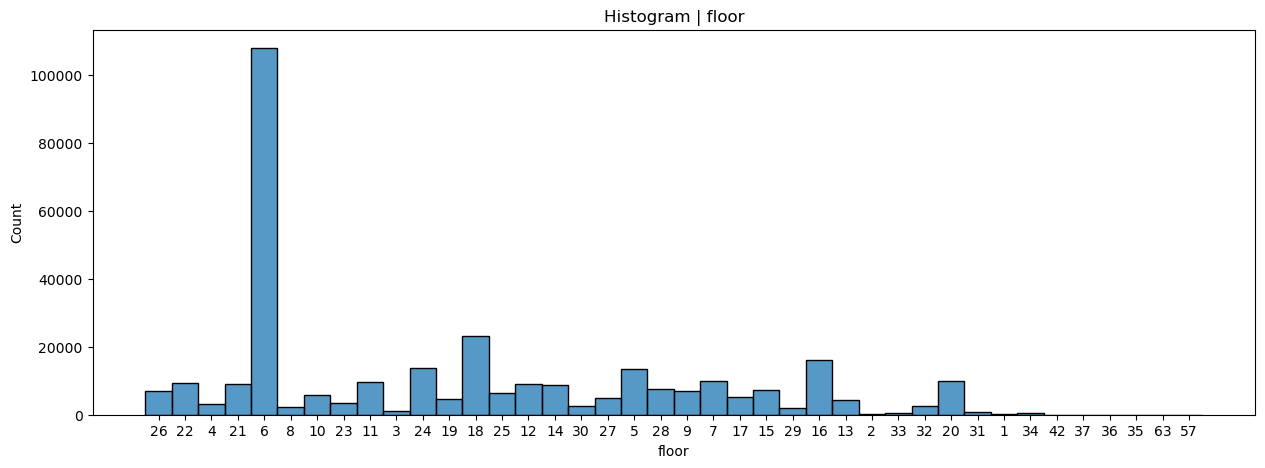

In [99]:
generateHistogram(df=gbk_rawData, columnName="floor", bins=50);

In [100]:
chineseChar = gbk_rawData.floorType.unique()
chineseChar

array(['高 ', '中 ', '底 ', '低 ', '顶 ', '未知 ', '钢混结构', '混合结构'], dtype=object)

In [101]:
# create dict with translations
translationDict = {}
translationDict["高 "] = "High"
translationDict["中 "] = "Medium"
translationDict["底 "] = "Bottom"
translationDict["低 "] = "Low"
translationDict["顶 "] = "Top"
translationDict["未知 "] = "Unknown"
translationDict["钢混结构"] = "Steel-composite construction"
translationDict["混合结构"] = "Hybrid structure"
translationDict

{'高 ': 'High',
 '中 ': 'Medium',
 '底 ': 'Bottom',
 '低 ': 'Low',
 '顶 ': 'Top',
 '未知 ': 'Unknown',
 '钢混结构': 'Steel-composite construction',
 '混合结构': 'Hybrid structure'}

In [102]:
for index_label, row_series in gbk_rawData.iterrows():
    # For each row update the 'floorType' value to it's translation
    gbk_rawData.at[index_label , 'floorType'] = translationDict[row_series['floorType']]
gbk_rawData[["floor", "floorType"]].head()

,floor,floorType
0,26,High
1,22,High
2,4,Medium
3,21,Bottom
4,6,Medium


#### Add data to original df

In [103]:
data.rename(columns = {'floor':'floor_old'}, inplace = True)  # rename current floor column
data.drop(['floor_old'], axis=1, inplace=True)  # delete floor_old column
data.insert(0, "floor", gbk_rawData["floor"])  # add new floor column to df
data.insert(0, "floorType", gbk_rawData["floorType"])  # add new floorType column to df
data[["floor", "floorType"]]

,floor,floorType
0,26,High
1,22,High
2,4,Medium
3,21,Bottom
4,6,Medium
...,...,...
318846,5,Medium
318847,24,Medium
318848,7,Medium
318849,5,Medium


#### Convert dtypes

Let pandas detect dtypes automatically

In [104]:
dfn = data.convert_dtypes()
dfn.dtypes

floorType               string
floor                   string
url                     string
id                      object
Lng                    Float64
Lat                    Float64
Cid                      Int64
tradeTime               string
DOM                      Int64
followers                Int64
totalPrice             Float64
price                    Int64
square                 Float64
livingRoom              object
drawingRoom             object
kitchen                  Int64
bathRoom                object
buildingType           Float64
constructionTime        string
renovationCondition      Int64
buildingStructure        Int64
ladderRatio            Float64
elevator                 Int64
fiveYearsProperty        Int64
subway                   Int64
district                 Int64
communityAverage         Int64
dtype: object

##### Convert dtypes manually
errors:
- If ‘raise’, then invalid parsing will raise an exception.
- If ‘coerce’, then invalid parsing will be set as NaN.
- If ‘ignore’, then invalid parsing will return the input.

In [105]:
data["tradeTime"] = pd.to_datetime(data["tradeTime"], format="%Y-%m-%d")  # Convert date to correct dtype
data["id"] = pd.to_numeric(data["id"], errors='coerce')
data["livingRoom"] = pd.to_numeric(data["livingRoom"], errors='coerce')
data["drawingRoom"] = pd.to_numeric(data["drawingRoom"], errors='coerce')
data["bathRoom"] = pd.to_numeric(data["bathRoom"], errors='coerce')
data["constructionTime"] = pd.to_numeric(data["constructionTime"], errors='coerce')
data["constructionTime"] = data.constructionTime.astype("object")  # to process the variable as categorical variable later
data["buildingType"] = pd.to_numeric(data["buildingType"], errors='coerce')
data["buildingType"] = data.buildingType.astype("object")  # to process the variable as categorical variable later
#data["constructionTime"] = pd.to_datetime(data["constructionTime"], format="%Y")
data["floor"] = pd.to_numeric(data["floor"], errors='coerce')
data["floorType"] = data["floorType"].astype("string")

In [106]:
data.dtypes

floorType                      string
floor                         float64
url                            object
id                            float64
Lng                           float64
Lat                           float64
Cid                             int64
tradeTime              datetime64[ns]
DOM                           float64
followers                       int64
totalPrice                    float64
price                           int64
square                        float64
livingRoom                    float64
drawingRoom                   float64
kitchen                         int64
bathRoom                      float64
buildingType                   object
constructionTime               object
renovationCondition             int64
buildingStructure               int64
ladderRatio                   float64
elevator                      float64
fiveYearsProperty             float64
subway                        float64
district                        int64
communityAve

#### Split date column into multiple columns

In [107]:
data = splitDateColumn(df=data, columnName="tradeTime")

#### First investigation of empty values

In [108]:
data.isnull().mean()

floorType                 0.000000
floor                     0.000100
url                       0.000000
id                        0.710787
Lng                       0.000000
Lat                       0.000000
Cid                       0.000000
tradeTime                 0.000000
DOM                       0.495457
followers                 0.000000
totalPrice                0.000000
price                     0.000000
square                    0.000000
livingRoom                0.000100
drawingRoom               0.000100
kitchen                   0.000000
bathRoom                  0.000006
buildingType              0.006338
constructionTime          0.060477
renovationCondition       0.000000
buildingStructure         0.000000
ladderRatio               0.000000
elevator                  0.000100
fiveYearsProperty         0.000100
subway                    0.000100
district                  0.000000
communityAverage          0.001452
tradeTimeYear             0.000000
tradeTimeMonth      

In [109]:
data.isna().sum()

floorType                      0
floor                         32
url                            0
id                        226635
Lng                            0
Lat                            0
Cid                            0
tradeTime                      0
DOM                       157977
followers                      0
totalPrice                     0
price                          0
square                         0
livingRoom                    32
drawingRoom                   32
kitchen                        0
bathRoom                       2
buildingType                2021
constructionTime           19283
renovationCondition            0
buildingStructure              0
ladderRatio                    0
elevator                      32
fiveYearsProperty             32
subway                        32
district                       0
communityAverage             463
tradeTimeYear                  0
tradeTimeMonth                 0
tradeTimeDay                   0
tradeTime_

### Drop unnecessary columns

In [110]:
data.drop(['DOM'], axis=1, inplace=True)  # Too many missing values -> 50%
data.drop(['id', 'url'], axis=1, inplace=True)  # IDs and URLs are not needed

### Drop unnecessary rows

We drop the 32 rows that contain missing values in many different columns because imputation could lead to too much error

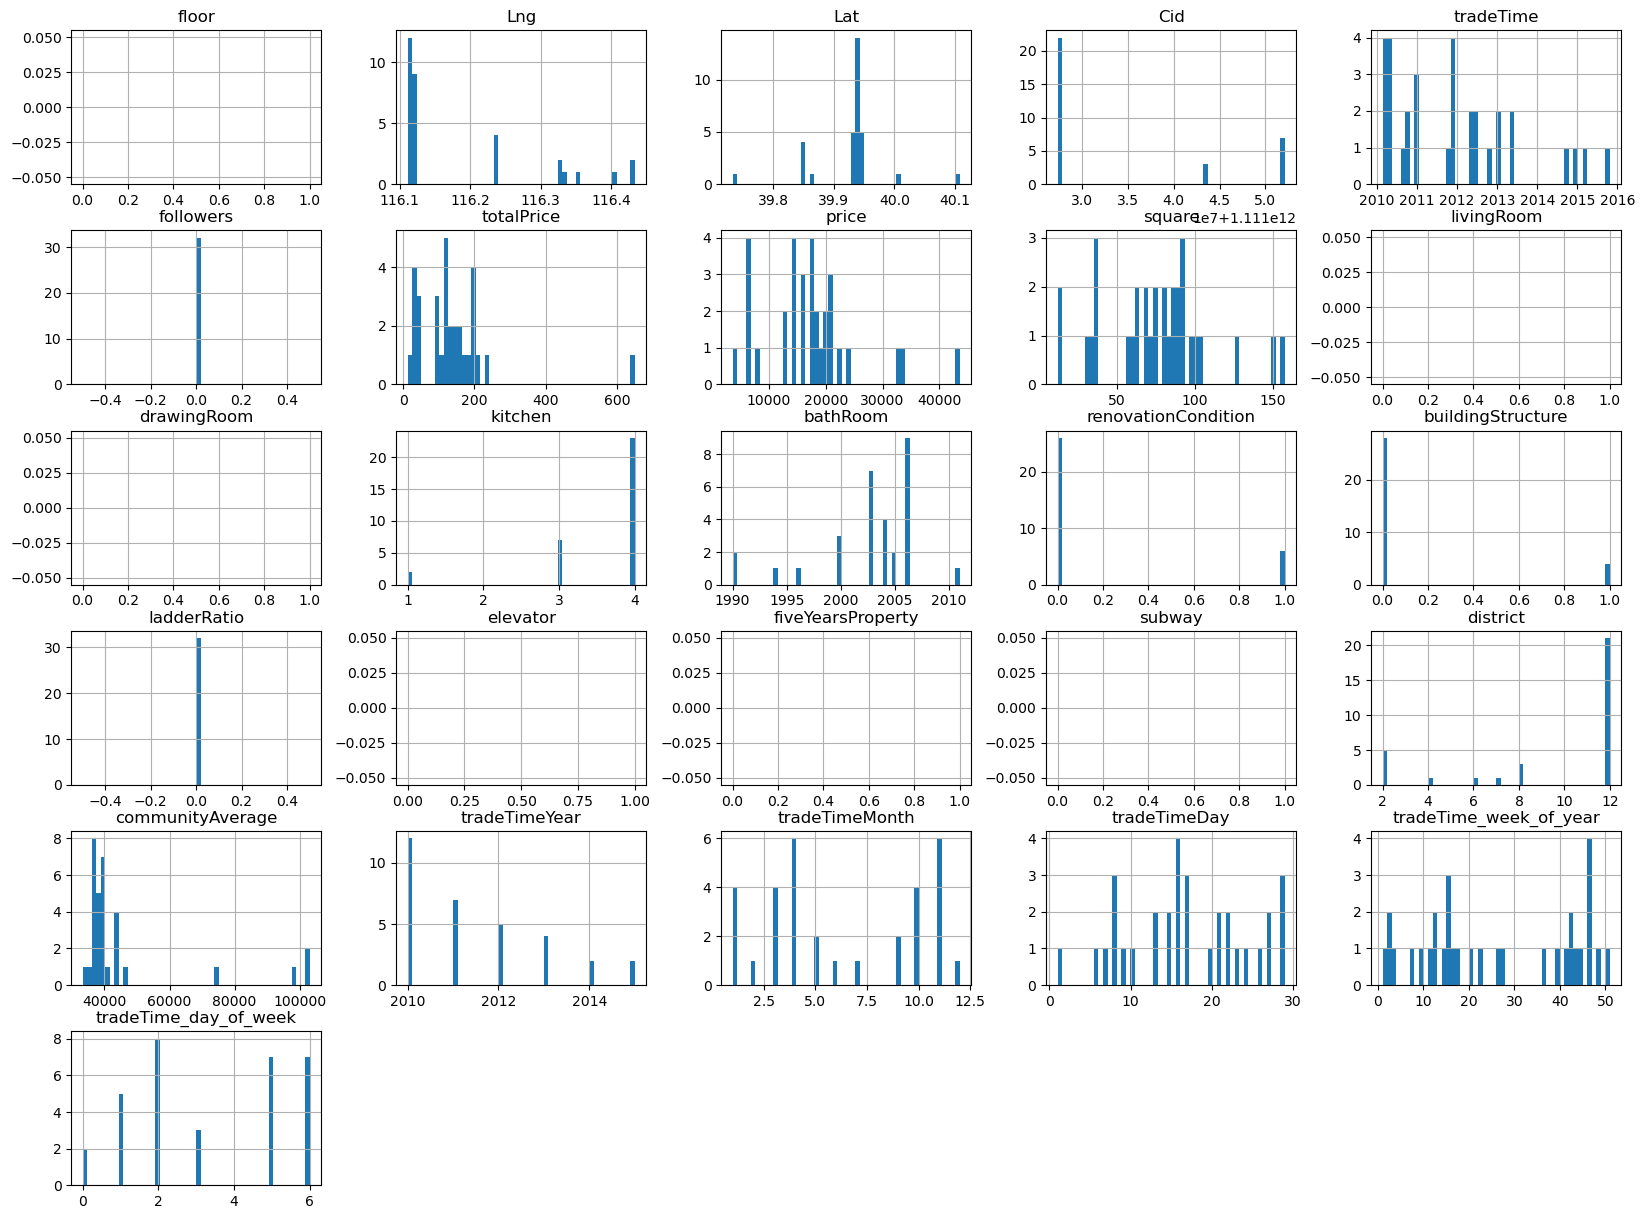

In [111]:
data[data.constructionTime.isin([0, 1])].hist(bins=50, figsize=(20,15))
plt.show();

In [112]:
data = data[data.constructionTime.isin([0, 1]) == False]  # drop rows

### Missing values

In [113]:
missingValues = getMissingValuesDF(data)
missingValues

,columnName,missingValuePercentage
0,buildingType,0.006339
1,constructionTime,0.060483
2,communityAverage,0.001452


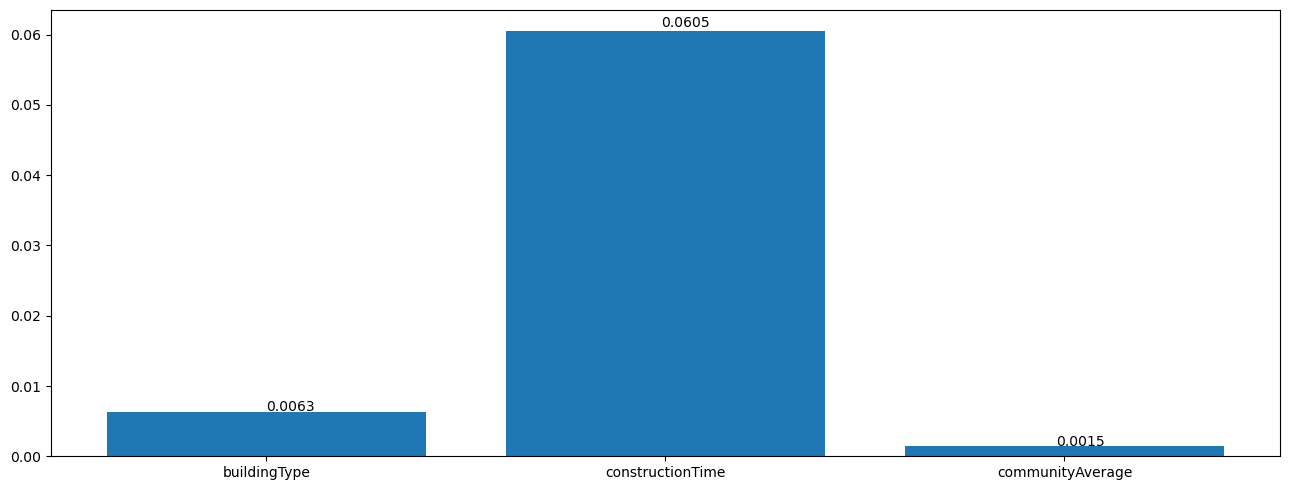

In [114]:
fig= plt.figure(figsize=(13,5))
generateBarChart(x=missingValues['columnName'], y=missingValues['missingValuePercentage'])
fig.tight_layout()
fig.show()

In [115]:
missingValueColumns = missingValues['columnName'].to_list()
missingValueColumns

['buildingType', 'constructionTime', 'communityAverage']

#### Check if missing values are missing at random

In [116]:
for missingValueColumn in missingValueColumns:
    print('-------------------------------------------------------------------------------------------------------------')
    getMissingValuesGroupedBy(df=data, missingValueColumn = missingValueColumn, groupByColumn = 'district')

-------------------------------------------------------------------------------------------------------------
Percentage of missing values in the buildingType variable: 0.00633901994548631
Percentage of missing values in the buildingType variable grouped by: district
1     0.005560
2     0.001500
3     0.036657
4     0.015609
5     0.097462
6     0.014987
7     0.003562
8     0.000942
9     0.002462
10    0.002077
11    0.002218
12    0.000000
13    0.015323
Name: buildingType_null, dtype: float64
-------------------------------------------------------------------------------------------------------------
Percentage of missing values in the constructionTime variable: 0.0604825935719013
Percentage of missing values in the constructionTime variable grouped by: district
1     0.064790
2     0.048716
3     0.093417
4     0.046304
5     0.032487
6     0.061838
7     0.053048
8     0.068854
9     0.080204
10    0.063081
11    0.131244
12    0.038027
13    0.023147
Name: constructionTime_null

---

>We should only use variables/columns with less than 5% missing values according to Soldedad Galli (2017).

>We have one variable with 6% missing values which we should not drop and try to fill up.

In [117]:
print("Columns with less than 5% missing Values:", [column for column in missingValueColumns if data[column].isnull().mean() < 0.05])
print("-------------------------------------------------------------------------------------")
print("Columns with more than 5% missing Values:", [column for column in missingValueColumns if data[column].isnull().mean() > 0.05])

Columns with less than 5% missing Values: ['buildingType', 'communityAverage']
-------------------------------------------------------------------------------------
Columns with more than 5% missing Values: ['constructionTime']


In [118]:
dataWithNA = data[data.isnull().any(axis=1)]  # rows with na values
dataWithNA = dataWithNA[missingValueColumns]  # select only columns with missing values
dataWithNA.info()  # shows total rows with na values and how they are distributed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21118 entries, 10 to 318850
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   buildingType      19097 non-null  object 
 1   constructionTime  1835 non-null   object 
 2   communityAverage  20655 non-null  float64
dtypes: float64(1), object(2)
memory usage: 659.9+ KB


### Train and Test sample

Before starting with the imputation of missing values we need to split the dataset because we don't want to affect the test sample after the modelling.

In [119]:
colsToUse = data.columns.to_list()  # all columns
colsToUse.remove('totalPrice')  # remove target variable (predicting variable)
colsToUse.remove('price')  # remove price variable to not impact model

X_train, X_test, y_train, y_test = train_test_split(
    data[colsToUse],
    data['totalPrice'],  # target
    test_size=0.3,
    random_state=6)

print("Shape:")
print("(X_train, X_test):", X_train.shape, X_test.shape)
print("(y_train, y_test):", y_train.shape, y_test.shape)

Shape:
(X_train, X_test): (223173, 27) (95646, 27)
(y_train, y_test): (223173,) (95646,)


### Feature engineering
[GitHub Source used](https://github.com/solegalli/feature-engineering-for-machine-learning/blob/main/Section-13-Putting-it-altogether/13.02-Regression-house-prices.ipynb)

First we categorize all our columns for later processing

In [120]:
categoricalColumns = ["floorType", "buildingType", "renovationCondition", "buildingStructure"]

In [121]:
temporalColumns = ["tradeTime", "constructionTime", "tradeTimeYear", "tradeTimeMonth", "tradeTimeDay", "tradeTime_week_of_year", "tradeTime_day_of_week"]

In [122]:
discreteColumns = getDiscreteColumns(df=X_train, excludeColumns = temporalColumns+categoricalColumns, maxNumUniqueLabels=50)

floor values:  [17.  8.  6. 18. 16.  5. 21. 30.  4. 25. 15. 29.  7. 28. 20. 24. 27. 12.
 22. 19. 26. 13. 11. 10. 23. 14.  9. 31. 32. 34.  3.  2.  1. 33. 42. 36.
 63. 37. 57. 35.]
livingRoom values:  [1. 3. 4. 2. 5. 6. 7. 0. 8. 9.]
drawingRoom values:  [1. 2. 0. 3. 4. 5.]
kitchen values:  [1 0 2 3 4]
bathRoom values:  [1. 0. 2. 3. 4. 5. 7. 6.]
elevator values:  [1. 0.]
fiveYearsProperty values:  [0. 1.]
subway values:  [1. 0.]
district values:  [ 4  7 10  8  2  6  1  9 11 13  5  3 12]

There are 9 discrete variables


In [123]:
if len(X_train.columns) == len(categoricalColumns + temporalColumns + discreteColumns):
    print("All columns categorized!")
else:
    continuousColumns=[]
    notCategorized=[]
    for i in X_train.columns.tolist():
        if i not in (categoricalColumns + temporalColumns + discreteColumns):
            if X_train[i].dtype.kind in 'iufc':  # check dtype (b bool, i int (signed), u unsigned int, f float, c complex)
                continuousColumns.append(i)
            else:
                print(notCategorized.append(i))
print(f"Following columns not categorized: {notCategorized}")
print(f"There are following {len(continuousColumns)} continuous variables: {continuousColumns}")

Following columns not categorized: []
There are following 7 continuous variables: ['Lng', 'Lat', 'Cid', 'followers', 'square', 'ladderRatio', 'communityAverage']


### Missing value imputation

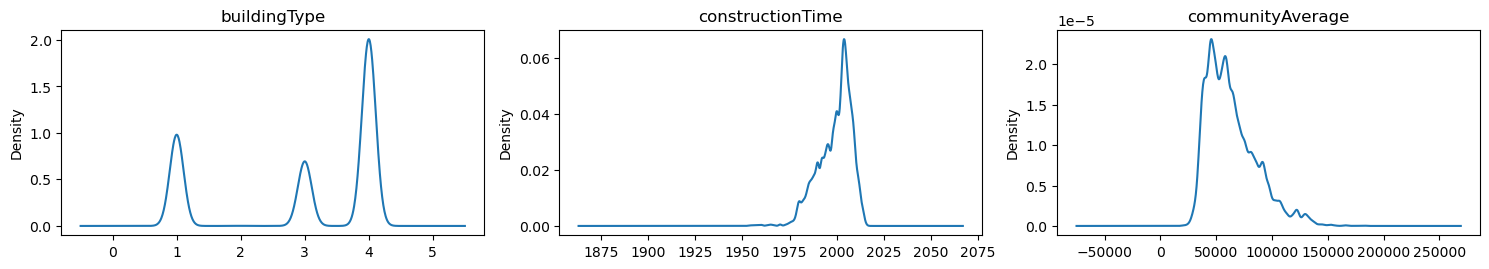

In [124]:
fig = generateDensityPlot(columns=missingValueColumns, df=X_train)  # Let's have a look at the distribution of the missing data
fig.tight_layout()
plt.show()

The communityAverage variable is skewed so we can use the median imputation method. For the other variables we need to use categorical imputation methods.

#### communityAverage imputation

For the communityAverage variable we use the median as imputation method because the data is skewed and there aren't many missing values

In [125]:
medianImputer = MeanMedianImputer(imputation_method='median', variables=['communityAverage'])  # imputation strategy: median gets imputed
medianImputer.fit(X_train)  # fit imputer
print(f'Variables used in the imputation step: {medianImputer.variables_}')
print(f'The dictionary with the median values used for the imputation: {medianImputer.imputer_dict_}')

Variables used in the imputation step: ['communityAverage']
The dictionary with the median values used for the imputation: {'communityAverage': 59015.0}


In [126]:
# transform the data
train_mI = medianImputer.transform(X_train)
test_mI = medianImputer.transform(X_test)

#### buildingType imputation

For the buildingType variable we use the most frequent category for imputation.

In [127]:
categoricalImputer = CategoricalImputer(imputation_method='frequent', variables=['buildingType'])  # imputation strategy: most frequent category gets imputed
categoricalImputer.fit(X_train)  # fit imputer
print(f'Variables used in the imputation step: {categoricalImputer.variables_}')
print(f'The dictionary with the median values used for the imputation: {categoricalImputer.imputer_dict_}')

Variables used in the imputation step: ['buildingType']
The dictionary with the median values used for the imputation: {'buildingType': 4.0}


In [128]:
# transform the data
train_cI = medianImputer.transform(X_train)
test_cI = medianImputer.transform(X_test)

#### constructionTime imputation

Because in the constructionTime variable we have many missing values we create a new label to represent a missing value

In [129]:
categoricalImputer = CategoricalImputer(imputation_method='missing', variables=['constructionTime'])  # imputation strategy: a new 'missing' category gets imputed
categoricalImputer.fit(X_train)  # fit imputer
print(f'Variables used in the imputation step: {categoricalImputer.variables_}')
print(f'The dictionary with the median values used for the imputation: {categoricalImputer.imputer_dict_}')

Variables used in the imputation step: ['constructionTime']
The dictionary with the median values used for the imputation: {'constructionTime': 'Missing'}


In [130]:
# transform the data
train_cIM = medianImputer.transform(X_train)
test_cIM = medianImputer.transform(X_test)

#### Missing value imputation pipeline

In [131]:
# Define the pipeline
missingValuePipe = Pipeline([
    ('median_imputer', MeanMedianImputer(imputation_method='median', variables=['communityAverage'])),
    ('frequent_category_imputer', CategoricalImputer(imputation_method='frequent', variables=['buildingType'])),
    ('missing_category_imputer', CategoricalImputer(imputation_method='missing', variables=['constructionTime']))
])

# Fit the pipeline
missingValuePipe.fit(X_train)

print(missingValuePipe.named_steps['median_imputer'].imputer_dict_)
print(missingValuePipe.named_steps['frequent_category_imputer'].imputer_dict_)
print(missingValuePipe.named_steps['missing_category_imputer'].imputer_dict_)

{'communityAverage': 59015.0}
{'buildingType': 4.0}
{'constructionTime': 'Missing'}


In [132]:
X_train = missingValuePipe.transform(X_train)  # Save imputed data to original X_train
X_train[missingValueColumns].isnull().sum()

buildingType        0
constructionTime    0
communityAverage    0
dtype: int64

In [133]:
X_test = missingValuePipe.transform(X_test)  # Save imputed data to original X_test
X_test[missingValueColumns].isnull().sum()

buildingType        0
constructionTime    0
communityAverage    0
dtype: int64

We eliminated the missing values successfully!

### Label encoding

We should encode following columns we defined above

In [134]:
categoricalColumns

['floorType', 'buildingType', 'renovationCondition', 'buildingStructure']

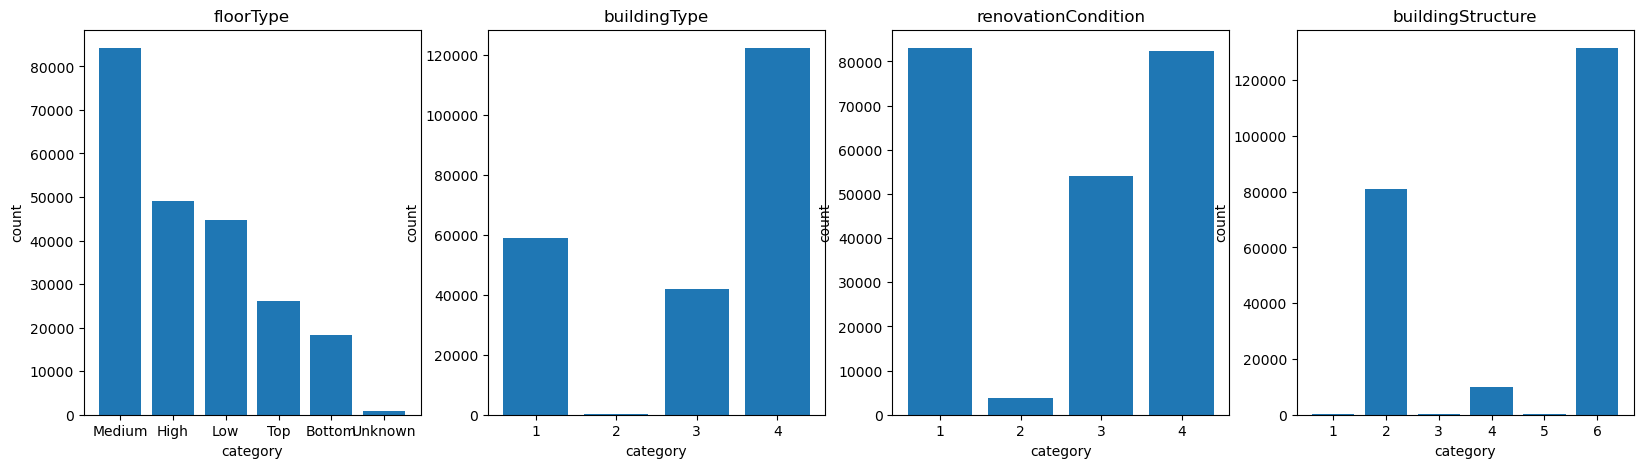

In [135]:
plt.figure(figsize=(20,5))
i=0
for category in categoricalColumns:
    i+=1
    plt.subplot(1,4,i)
    plt.bar(X_train[category].value_counts().index, X_train[category].value_counts().values)
    plt.title(category)
    plt.ylabel("count")
    plt.xlabel("category")
plt.show()

#### Rare labels

In [136]:
for category in categoricalColumns:
    print(detectRareLabels(X_train, columnName=category), "\n")

Number of labels in the floorType variable: 6
List of the labels in the floorType variable: <StringArray>
['Low', 'Medium', 'High', 'Bottom', 'Top', 'Unknown']
Length: 6, dtype: string
Value counts percentage for each label:
Medium     0.377366
High       0.219579
Low        0.200002
Top        0.117169
Bottom     0.081824
Unknown     0.00406
Name: floorType, dtype: Float64 

Number of labels in the buildingType variable: 4
List of the labels in the buildingType variable: [3. 4. 1. 2.]
Value counts percentage for each label:
4.0    0.547956
1.0    0.264450
3.0    0.187182
2.0    0.000412
Name: buildingType, dtype: float64 

Number of labels in the renovationCondition variable: 4
List of the labels in the renovationCondition variable: [1 3 4 2]
Value counts percentage for each label:
1    0.372075
4    0.368768
3    0.242140
2    0.017018
Name: renovationCondition, dtype: float64 

Number of labels in the buildingStructure variable: 6
List of the labels in the buildingStructure variable

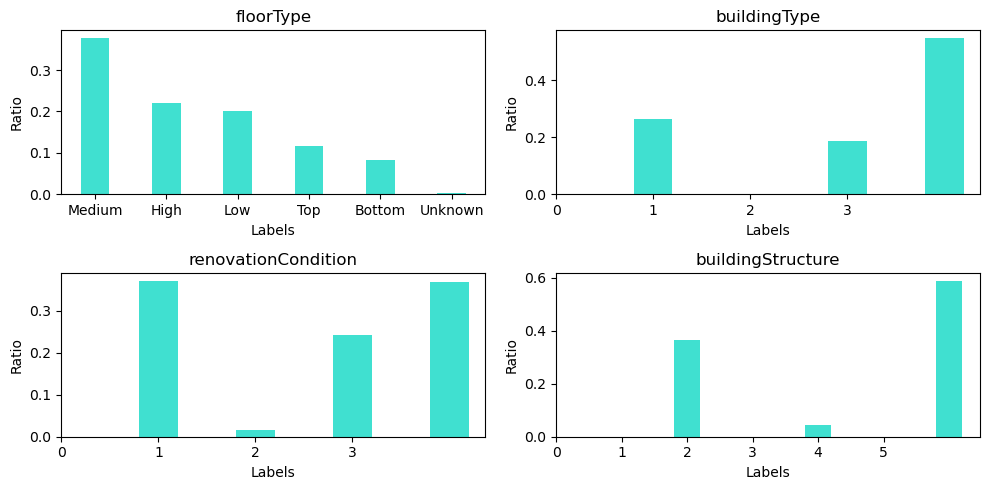

In [137]:
fig = visualizeRareLabels(X_train, columnNames=categoricalColumns, figsize=(10,5))
fig.tight_layout()
plt.show()

Because there are some rare labels we encode the data with a count/frequency encoder to avoid inflation of the dataset and to add weight to the labels (by encoding each label with its value count)

In [138]:
# change dtype of categorical columns to object dtype so it can be processed
for category in categoricalColumns:
    X_train[category] = X_train[category].astype("object")

In [139]:
'''
oneHotEnc = fe_OneHotEncoder(
    top_categories=None,
    variables=categoricalColumns,  # we can select which variables to encode
    drop_last=True  # to return k-1, false to return k
)
oneHotEnc.fit(X_train)
oneHotEnc.variables_
'''

'\noneHotEnc = fe_OneHotEncoder(\n    top_categories=None,\n    variables=categoricalColumns,  # we can select which variables to encode\n    drop_last=True  # to return k-1, false to return k\n)\noneHotEnc.fit(X_train)\noneHotEnc.variables_\n'

In [140]:
countEncoder = CountFrequencyEncoder(
    encoding_method='count', # to do frequency ==> encoding_method='frequency'
    variables=categoricalColumns
)
countEncoder.fit(X_train)
countEncoder.encoder_dict_

{'floorType': {'Medium': 84218,
  'High': 49004,
  'Low': 44635,
  'Top': 26149,
  'Bottom': 18261,
  'Unknown': 906},
 'buildingType': {4.0: 122289, 1.0: 59018, 3.0: 41774, 2.0: 92},
 'renovationCondition': {1: 83037, 4: 82299, 3: 54039, 2: 3798},
 'buildingStructure': {6: 131520, 2: 81082, 4: 10114, 3: 177, 1: 144, 5: 136}}

In [141]:
test_cfE = countEncoder.transform(X_test)

In [142]:
X_train = countEncoder.transform(X_train)  # Save encoded data to original X_train

In [143]:
X_test = countEncoder.transform(X_test)  # Save encoded data to original X_test

We encoded the categorical features successfully!

**Reference**
>Galli, S. (2017). Feature Engineering for Machine Learning, https://github.com/solegalli/feature-engineering-for-machine-learning, Accessed on 26.10.2022.

### Distribution of variables

We should start with the Shapiro-Wilk Test. It is the most powerful test to check the normality of a variable. It was proposed in 1965 by Samuel Sanford Shapiro and Martin Wilk.

- If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.

- If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

In [163]:
shapiroWilkTest(data=X_train, columnNames=categoricalColumns)

stat=0.830, p=0.000
Column "floorType" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.701, p=0.000
Column "buildingType" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.568, p=0.000
Column "renovationCondition" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.678, p=0.000
Column "buildingStructure" probably not Gaussian distributed!
------------------------------------------------------------


In [162]:
shapiroWilkTest(data=X_train, columnNames=discreteColumns)

stat=0.873, p=0.000
Column "floor" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.834, p=0.000
Column "livingRoom" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.696, p=0.000
Column "drawingRoom" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.088, p=0.000
Column "kitchen" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.492, p=0.000
Column "bathRoom" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.628, p=0.000
Column "elevator" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.607, p=0.000
Column "fiveYearsProperty" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.620, p=0.000
Column "subway" probably not Gau

In [164]:
shapiroWilkTest(data=X_train, columnNames=continuousColumns)

stat=0.179, p=0.000
Column "Lng" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.828, p=0.000
Column "Lat" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.001, p=0.000
Column "Cid" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.490, p=0.000
Column "followers" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.859, p=0.000
Column "square" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.000, p=0.000
Column "ladderRatio" probably not Gaussian distributed!
------------------------------------------------------------
stat=0.931, p=0.000
Column "communityAverage" probably not Gaussian distributed!
------------------------------------------------------------


**Reference**
>Sivasai Yadav Mudugandla (2020). 10 Normality Tests in Python (Step-By-Step Guide 2020), https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411, Accessed on 03.11.2022.

### Feature selection

#### Quasi-constant features

We can drop constant or quasi-constant features with the function DropConstantFeatures from feature engine.

In [179]:
dropConstantFeatures = DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')  # quasi-constant drop as tol is not equal to 1, with tol = 1 we get constant feature dropping
dropConstantFeatures.fit(X_train)

print("Number of quasi-constant features:", len(dropConstantFeatures.features_to_drop_))  # number of quasi-constant features
print("Features:", dropConstantFeatures.features_to_drop_)  # list of quasi-constant features

Number of quasi-constant features: 1
Features: ['kitchen']


In [180]:
X_train = dropConstantFeatures.transform(X_train)
X_test = dropConstantFeatures.transform(X_test)

#### Duplicates

In [181]:
dropDuplicateFeatures = DropDuplicateFeatures(variables=None, missing_values='raise')
dropDuplicateFeatures.fit(X_train)  # find the duplicate features, this might take a while

print("Number of duplicate features:", len(dropDuplicateFeatures.features_to_drop_))
print("Duplicate feature sets:", dropDuplicateFeatures.duplicated_feature_sets_)
print("Features that will be dropped", dropDuplicateFeatures.features_to_drop_)

Number of duplicate features: 0
Duplicate feature sets: []
Features that will be dropped set()


In [182]:
X_train = dropDuplicateFeatures.transform(X_train)
X_test = dropDuplicateFeatures.transform(X_test)

#### Correlation Brut force approach

In [183]:
dropCorrelatedFeatures = DropCorrelatedFeatures(
    threshold=0.8,
    method='pearson',
    missing_values='ignore'
)

dropCorrelatedFeatures.fit(X_train)  # find correlated features
print("Correlated feature sets:", dropCorrelatedFeatures.correlated_feature_sets_)

Correlated feature sets: [{'tradeTime_week_of_year', 'tradeTimeMonth'}]


In [184]:
X_train = dropCorrelatedFeatures.transform(X_train)
X_test = dropCorrelatedFeatures.transform(X_test)

### Correlations

In [145]:
# Create a df with the train data for analysis
trainDF = X_train.copy()
trainDF["totalPrice"] = y_train  # Add label / predicting variable

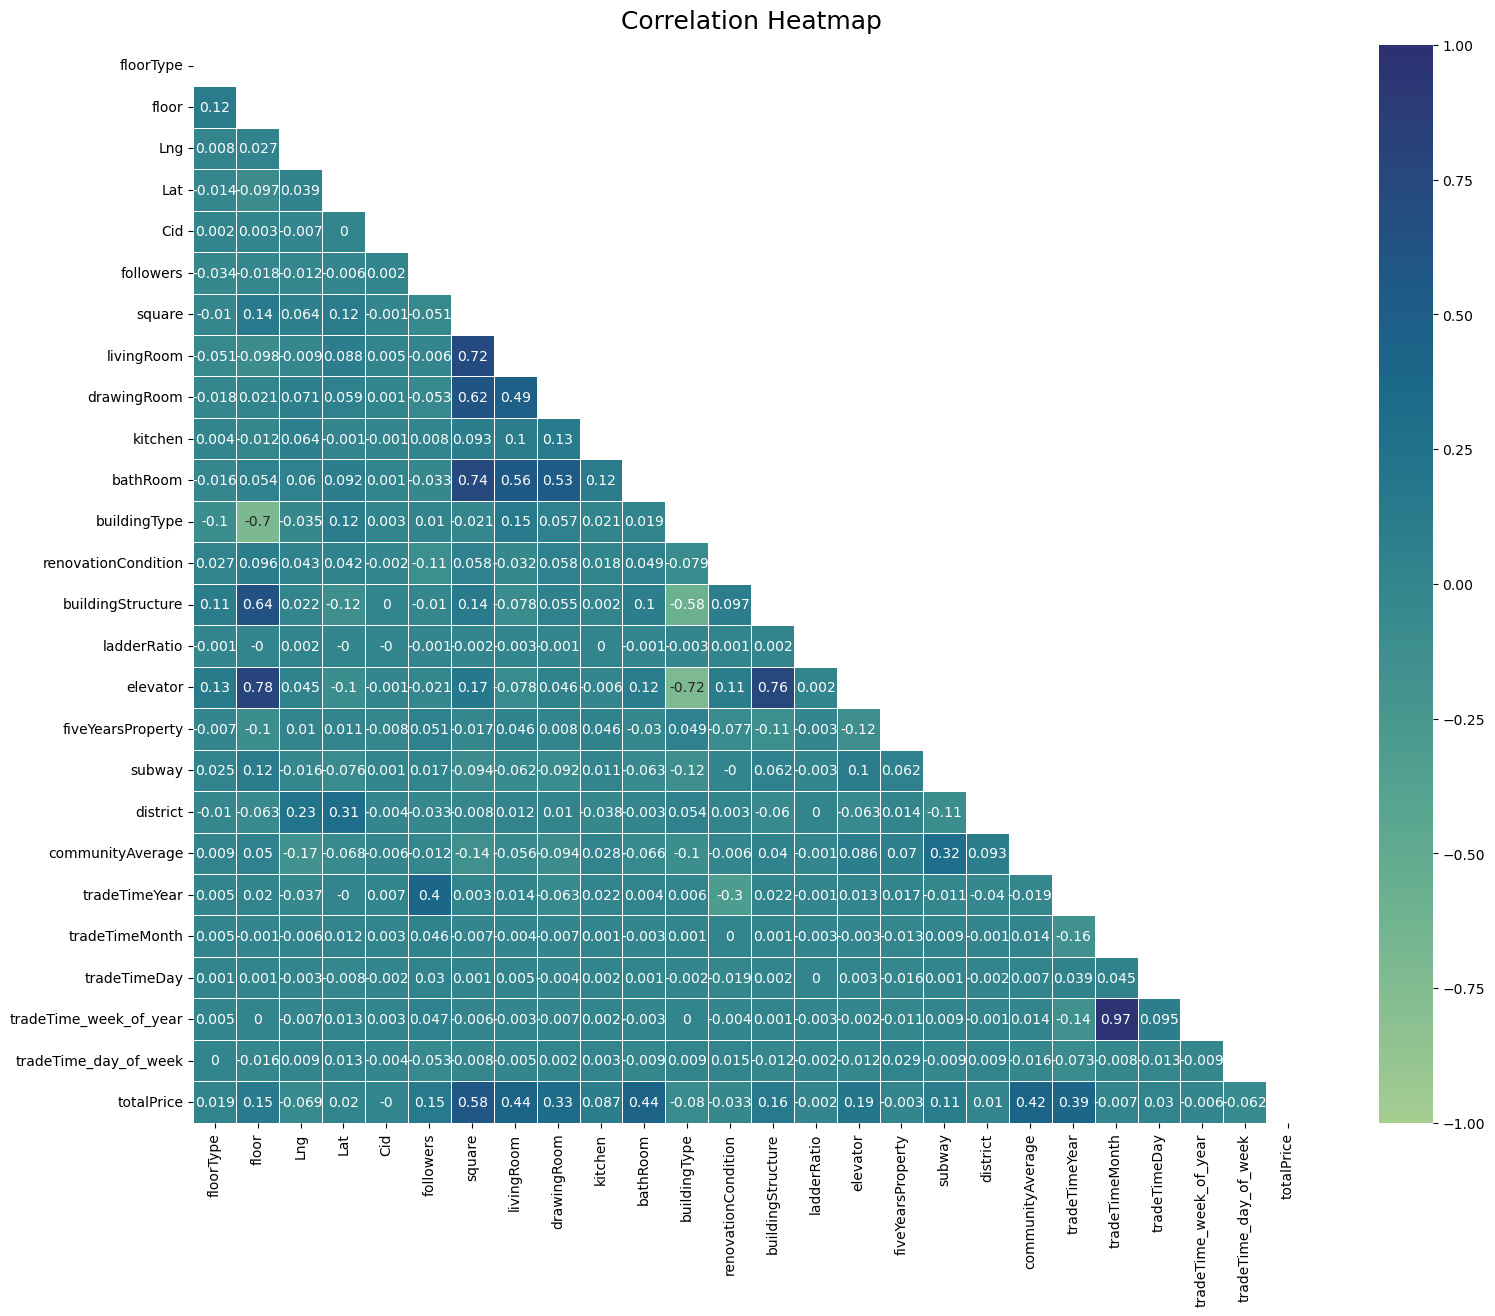

In [146]:
generateCorrelationPlot(df=trainDF, figsize=(18,14))

### Diagnostic plots

Text(0, 0.5, 'Median House price')

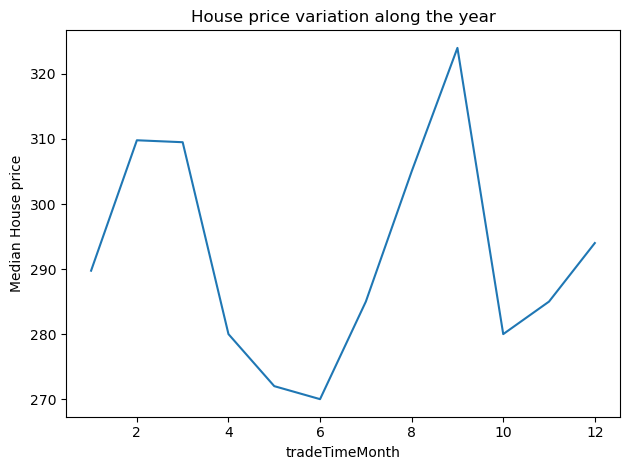

In [147]:
trainDF.groupby('tradeTimeMonth')['totalPrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('Median House price')

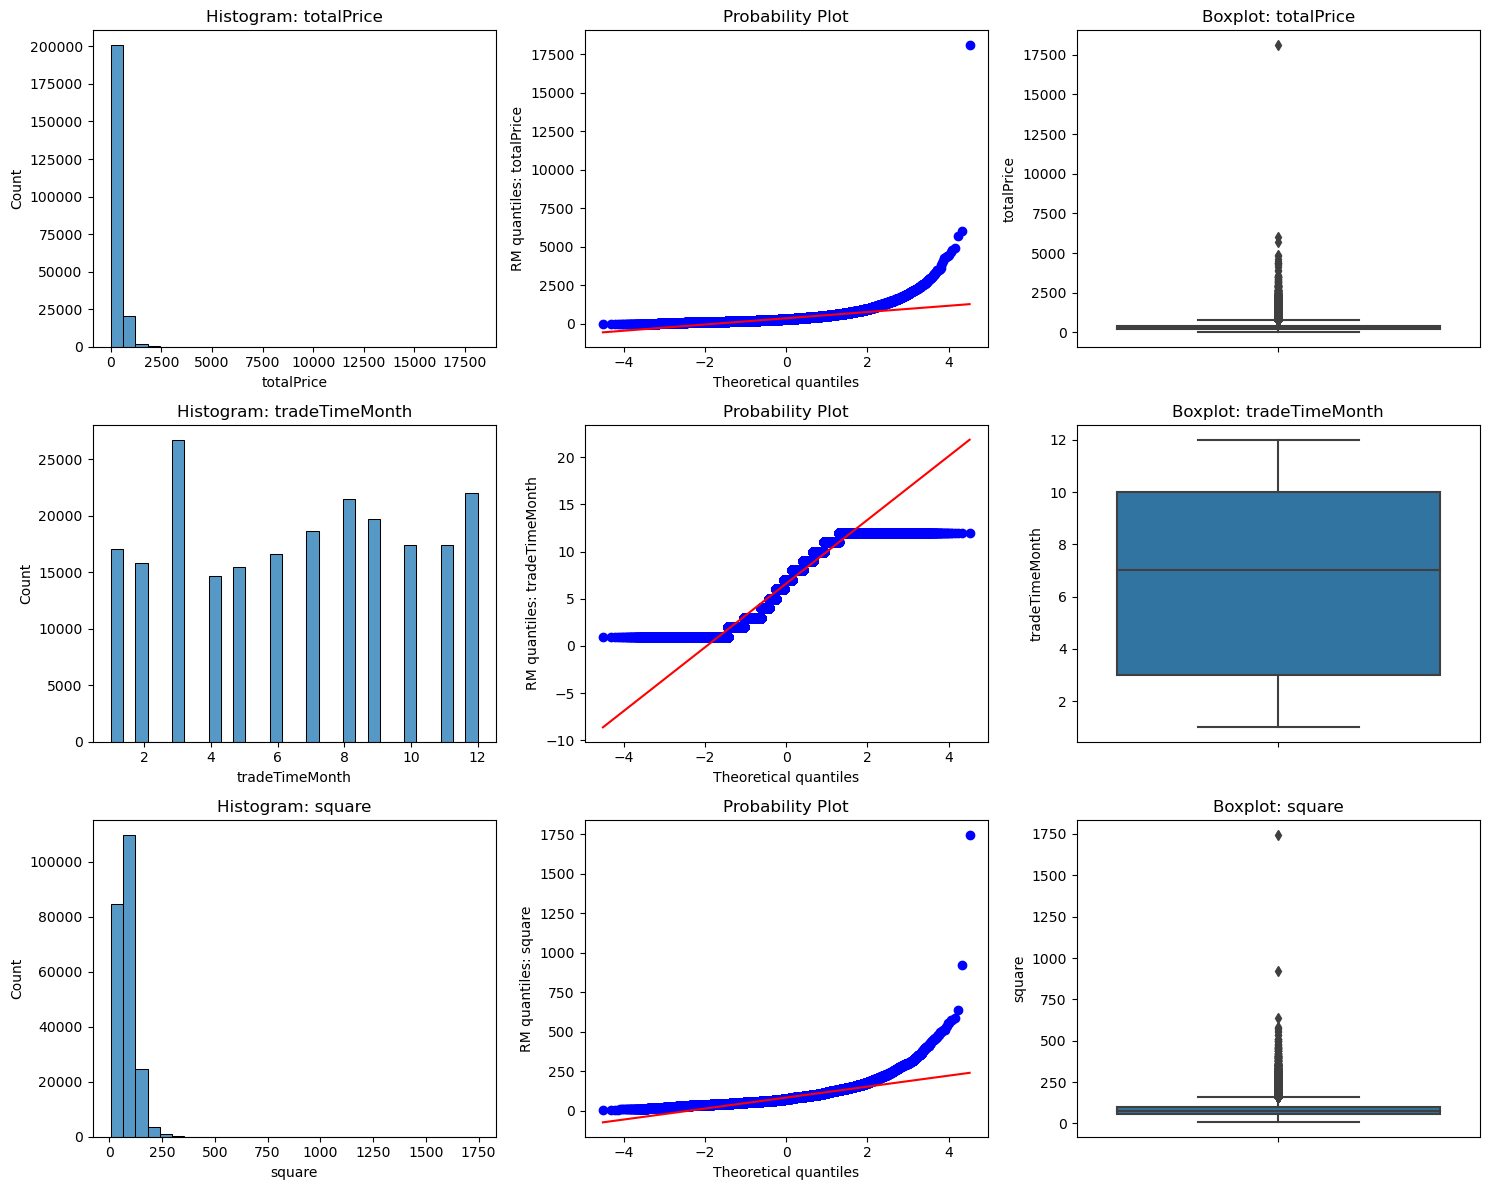

In [148]:
fig = generateDiagnosticPlots(trainDF, columnNames=["totalPrice", "tradeTimeMonth", "square"])
fig.tight_layout()
fig.show()

### Outliers

In [149]:
detectSkewedBoundaries(trainDF, 'totalPrice', 1.5)

upper boundary: 757.5 | lower boundary: -126.5
total number of rows: 223173
Having totalPrice changes: 11072
% of having totalPrice: 0.0496117361867251


In [150]:
detectNormalBoundaries(trainDF, 'totalPrice')

upper boundary: 1044.8392152639667 | lower boundary: -346.0731647112949
total number of rows: 223173
rows with more than 1044 (right end outliers): 3707
% right end outliers: 0.016610432265551835


### Baseline

To test if we can achieve a better result by using machine learning in a later step, we need to define a baseline.

In the baseline we predict the mean value for every row and return the MAE to compare it with our machine learning model later.

The machine learning model needs to return a lower MAE to be better.

In [151]:
getBaseline(df=data, predictionColumn="totalPrice", testSize=0.3)

Prediction variable is: totalPrice
---------------------------------------------------
len of y_train: 223173
train_base_MAE = 155.93
---------------------------------------------------
len of y_test: 95646
test_base_MAE = 156.13
---------------------------------------------------


End of the notebook :)